<a href="https://colab.research.google.com/github/zaidalyafeai/AttentioNN/blob/master/TransformerII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install sentencepiece
!wget http://data.mxnet.io/data/fra-eng.zip
!unzip fra-eng.zip

In [0]:
with open('fra.txt', 'r') as f:
  sentences = f.read().splitlines()
  en = [sentence.split('\t')[0] for sentence in sentences]
  fr = [sentence.split('\t')[0] for sentence in sentences]

with open('en.txt', 'w') as f:
  f.write(('\n'.join(en)))

with open('fr.txt', 'w') as f:
  f.write(('\n'.join(fr)))

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import sentencepiece as spm
import matplotlib.pyplot as plt

TensorFlow 2.x selected.


## Introduction 

Until 2017, natural language processing (NLP) was dependent on using recurrent neural networks (RNNs) which has many shortcomings: 1. no support for parallelization, 2. vanishing gradient for long sequences. For instance, in translation which is mostly seq2seq architectures, both the encoder and decoder consists of RNNs. In 2014, Bahdanau et al , suggested the use of a mechanism called "attention" to resolve the bottleneck of seq2seq models [1]. However, RNNs were still the main building blocks for such models and others like image captioning by Kelvin Xu et al [2]. The use of attention in [1, 2] gave a better visualization of such models. But, what if we get rid of all RNNs in the first place. Well, that is a big claim, but it worked really well in 2017. The paper was rightly called "Attention is all you need" by Vaswani et al. from Google AI. This is a breakthrough, since RNNs are very slow which makes parallel computations easy to implement. The model was called 'Transfomer model', in this notebook we will explain in details its main components. 

## Transformer Decoder

The transofmer, like other architectures for machine translation consists of encoder and decoder modules. In this notebook, we will only focus on the decoder, check the first part that discusses the [encoder](https://colab.research.google.com/github/zaidalyafeai/AttentioNN/blob/master/TransformerI.ipynb).

![alt text](https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png)

## Tokenization

Given a set of statements we would like to convert these statements to a set of integers. However, this will result in a huge vocabulary which makes training very difficult. Google offers [SentencePiece](https://github.com/google/sentencepiece) which is a model that could be trained to generate tokens for arbitrary languages. From the name, you could deduce that the model can generate pieces of words as well. In this example, we will train a model on a set of expressions from the English language. 

In [3]:
# train the model on the epxressions with a fixed vocabulary size, this will create a model named en.model 
spm.SentencePieceTrainer.Train('--input=en.txt --model_prefix=en --vocab_size=10000')

# create the process object then load the trained model
sp = spm.SentencePieceProcessor()
sp.load('en.model')

True

Now, let us load our dataset and convert them to padded vectors

In [0]:
# load the expressions 
with open('en.txt', 'r') as f:
  sentences = f.read().splitlines()

# convert the vectors to ids 
sequences = []
max_length = 0

for sentence in sentences[0:1000]:
  sequence = sp.encode_as_ids(sentence)
  sequences.append(sequence)
  max_length = max(max_length, len(sequence))

# pad the vectors according to the longest sequence 
x = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen = max_length, padding = 'post')

## Parameters
A set of parameters that are taken from the original paper. Don't worry about them right now. 

In [0]:
# dimension of the vectors between consecutive modules layers 
dm = 512

# number of heads in attention modules
h = 8 

# dimensnion of queries and keys 
dk = dm // 8

# dimension of values 
dv = dm // 8 

# sequence length 
n = max_length 

# size of vocabulary 
vocab_size = 10000

# number of neurons in the feed forward network 
dff = 2048

## Encoding
Since the transformer model has no meaning of sequences of operations (they are mostly parallel) for a set of words, it is important that we keep track of the order input words. To do that, we use positional encoding. Before doing that, we will first pass the vectors through an embedding layer

In [0]:
e = tf.keras.layers.Embedding(vocab_size, dm)(x)

To encode the position of each word within a sequence of models we use sines and cosines. These encodings are just added to the embedding layer output so no change in the shape of e: [None, dm]. 

Given pos as the position within the sequence which takes the values $0 \cdots n-1$ and $i$ as the position within the embedding dimension which takes values $0 \cdots d_m-1$. We evaluate the encoded position for even and odd values as 

$$\text{PE}(\text{pos},2i)= \sin\left(\frac{\text{pos}}{10000^{2i/d_{model}}}\right)$$

$$\text{PE}(\text{pos},2i+1)= \cos\left(\frac{\text{pos}}{10000^{2i/d_{model}}}\right)$$

We can combine the two formulas as 

$$\text{PE}(\text{pos},i)= \sin\left(\frac{\text{pos}}{10000^{(i-g(i))/d_{model}}}+ g(i) \times \frac{\pi}{2}\right)$$

Where $g(i) = i \,\% \,2$ which takes 0 for even values and 1 for odd values. Note that $\sin(x + \pi/2) = \cos(x)$

In [0]:
def g(ids):
  return ids % 2

def positional_encoding(x):

  # 1. create positions within sequence and ids within dm 
  # out ids: [1, dm] pos: [n, 1]
  ids = tf.expand_dims(tf.range(0, dm), 0)
  pos = tf.expand_dims(tf.range(0, n), 1)

  # 2. create numerator and denominator
  # inp ids: [1, dm] pos: [n, 1] 
  # out den: [1, dm] num: [n, 1]
  den = tf.pow(10000.0, tf.cast((ids - g(ids))/ dm, tf.float32))
  num = tf.cast(pos, tf.float32)

  # 3. division ahmed show
  # inp num: [n, 1] den: [1, dm] 
  # out encoding: [n, dm]
  encoding = tf.sin(tf.divide(num, den)  + tf.cast(g(ids), tf.float32)* (np.pi/2))
  return x + encoding
  

In [0]:
z = positional_encoding(e)

Let us visualize the encoding for a specific sequence of words. As we see from the figure there is a unique pattern for the sequence position in the y-axis. 

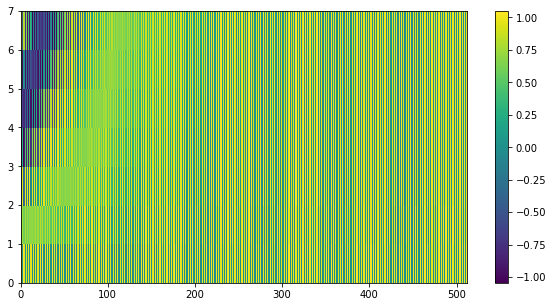

In [9]:
plt.figure(figsize = (10, 5))
plt.pcolormesh(z[0])
plt.ylim((0, max_length))
plt.colorbar()
plt.show()

## Masked Multi-head Self-attention

![alt text](https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/img/MultiHead.png)


Let us start by the output of the positional encoding function $z \in \mathbb{R}^{n \times d_m}$. Note that, for simplicity we assume that we just have one batch. From the value $z$ we extract three types of vectors by applying three dense layers. The types are $K \in \mathbb{R}^{n \times d_k} Q \in \mathbb{R}^{n \times d_k}$ and $V \in \mathbb{R}^{n \times d_v}$ called keys, queries and values respectively. In simple terms, the keys are used by the query vector to search for values. In attention, we are trying to find the closest key-value pair to the given query vector. In other words, we are trying to search for words that are closer in meaning or may refer to in the current context. For instance, in the statement `John is smart and handsome` we expect that the query words `smart` and `handsome` to have an high attention value for the key word `John`. To evaluate closensess, we a scaled dot product 

$$\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}}\right)V$$

This function will result in a weight vector for each query word multiplied by the value vector. For instance, for the query word `smart` we expect something like `[0.3, 0.05, 0.1, 0.05, 0.55] x v`. Hence, smaller values of the attention weight vector will result in smaller values and hence lower gradient. The authors, realized that for larger values the dot product might grow large so they divide by $\sqrt{d_k}$ as a normalizing factor inside the softmax function. In general, this is called additive attention which is usually preferred because is fast and space efficient because we can use highly optimized matrices product to compute it. Note that, in the definition we assume that $Q, K, V$ are matrices hence it can be computed really fast for a large sequence and even batch size. There exists another form of attention, which is called product attention which was used in [1, 2]. 

In general this approach is called self-attention because it uses the same input vector $z$ to generate the queue, key and value vectors. In the paper, the authors suggest using self-attention multiple times i.e multiple head attention. This is done by repeating the same operation multiple times which in general gave more robust results. They use $h = 8$  and then concatenate the output at the end. In the decocer the authors applied masked self-attention where the current token is only able to attent to all tokens proceeding it in position. Hence, they cannot see future values. Let us take an example, consider the following matirx 

$$\begin{bmatrix}
-1.37433722 &-0.53638396 & -0.36027966 \\
-1.15409807 & -1.54633265 & 1.04451533 \\
 1.25598085 & -0.52104727 & -1.08935325
\end{bmatrix}$$

We apply a simple trick by replacing upper traingle by - infinity values as a masking value

$$\begin{bmatrix}
-1.37433722 &-\infty & -\infty \\
-1.15409807 & -1.54633265 & -\infty \\
 1.25598085 & -0.52104727 & -1.08935325
\end{bmatrix}$$

By applying `softmax` function 

$$ \begin{bmatrix}
1.        & 0.    &     0. \\        
0.5968205 & 0.40317947 & 0.  \\      
0.79054177 & 0.13371228 & 0.07574591 \\
\end{bmatrix} $$

In the following function we will create a multi head attention operation. The input vector has dimensions $z \in \mathbb{R}^{\text{None} \times n \times d_m}$ and the output $H \in \mathbb{R}^{\text{None} \times n \times d_m}$ note how we use $\text{None}$ to represent the batch size which could be of variable size. To make the code clearer, for each operation I show the input and output dimension shapes. 

In [0]:
# mask previous tokens by replacing them with -inf th
def mask(x):
  # 1. scaled dot product 
  # inp x: [None, n, n]
  # out y: [None, n, n] 
  mask = tf.linalg.band_part(tf.ones((n, n)), -1, 0)
  y = x*mask+(mask-1)/mask
  return y

def h_linear(x, dout):
  # inp x:[None, n, dm] 
  # out x:[None, h, n, dout] 
  x = tf.keras.layers.Dense(units = dm)(x)
  x = tf.reshape(x, (-1, h, n, dout))
  return x

def multi_head_attention(Q, K, V, masked = False):

  # 0. apply linear layers 
  # inp Q:[None, n, dm] K: [None, h, n, dm] V: [None, h, n, dm] 
  # out Q:[None, h, n, dk] K: [None, h, n, dk] V: [None, h, n, dv]   
  Q = h_linear(Q, dk)
  K = h_linear(K, dk)
  V = h_linear(V, dv)

  # 1. scaled dot product 
  # inp Q:  [None, h, n, dk] K: [None, h, n, dk] 
  # out score : [None, h, n, n] 
  score = tf.matmul(Q, K, transpose_b=True)/ tf.sqrt(dk*1.0)

  # 3. evaluate the mask 
  # inp score: [None, h, n, n]
  # out score: [None, h, n, n]
  if masked:
    score = mask(score)

  # 3. evaluate the weights 
  # inp score: [None, h, n, n]
  # out W: [None, h, n, n]
  W = tf.nn.softmax(score, axis = -1)

  # 4. evaluate the context vector 
  # inp W: [None, h, n, n] V: [None, h, n, dv]
  # out H: [None, h, n, dv]
  H = tf.matmul(W, V)

  # 5. concatenate all heads
  # inp H: [None, h, n, dv]
  # out H: [None, n, dv*h]
  H = tf.reshape(H, (-1, n, dv * h))

  # 6. linear layer
  # inp H: [None, h, n, dv]
  # out H: [None, n, dm]
  out = tf.keras.layers.Dense(units = dm)(H)
  
  return out

Finally, the decoder layer will be ready by applying fully connected layers and normalizations. Note that the authors used residual connections $$\text{LayerNorm}(x + \text{Sublayer}(x))$$ 

In [0]:
def DecoderLayer(z, z_encoder):

  # 1. masked multi-head attention
  # inp z : [None, n, dm]
  # out dz: [None, n, dm]
  dz = multi_head_attention(z, z, z, masked = True)

  # 2. normalization
  # inp z: [None, n, dm] dz: [None, n, dm]
  # out z: [None, n, dm]
  z = tf.keras.layers.LayerNormalization()(z + dz)

  # 3. unmasked multi-head attention
  # inp z : [None, n, dm]
  # out dz: [None, n, dm]
  dz = multi_head_attention(z, z_encoder, z_encoder, masked = False)

  # 5. normalization
  # inp z: [None, n, dm] dz: [None, n, dm]
  # out z: [None, n, dm]
  z = tf.keras.layers.LayerNormalization()(z + dz)

  # 6. feed forward 
  # inp z : [None, n, dm]
  # out dz: [None, n, dm]
  dz = tf.keras.layers.Dense(units = dff, activation = 'relu')(z)
  dz = tf.keras.layers.Dense(units = dm)(dz)

  # 7. normalization 
  # inp z: [None, n, dm] dz: [None, n, dm]
  # out z: [None, n, dm]
  z = tf.keras.layers.LayerNormalization()(z + dz)

  return z 

In [20]:
DecoderLayer(z, z).shape

TensorShape([1000, 7, 512])

## References

1. [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473) 
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention
](https://arxiv.org/abs/1502.03044)
3.  [Attention is all you need](https://arxiv.org/abs/1706.03762)
4. https://www.tensorflow.org/tutorials/text/transformer
5. [The Illustrated GPT-2](http://jalammar.github.io/illustrated-gpt2/)